# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [4]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_08_04_lesser_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_mdn_08_04_lesser_ratio


In [5]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [6]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [7]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [8]:
samples_prior_list = samples_prior.unsqueeze(0)

In [9]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [10]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished


In [11]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [12]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.8209, 5.4826, 5.9819, 3.7542, 3.7644, 9.4424, 8.3950, 5.3740, 3.7668,
        8.7980, 2.1238, 4.2600, 2.0889, 8.2793, 4.2492])
tensor([11.0257, 24.5442, 29.4483,  8.8126, 71.9675, 51.8517, 36.7250, 43.5093,
         7.5624, 75.1965,  3.9979, 48.5736, 96.7557, 27.3633, 36.6214])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 41.7532, 184.7724,  60.2385,   5.9290, 167.8447,  46.7900,  79.8985,
         148.5376,  11.6137,  49.5296,   1.5042, 158.9635,   3.4635, 111.5036,
          42.1818]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 5.2743,  4.5911,  6.3331, 11.4201,  5.7830,  6.4292,  3.9878,  5.5516,
         4.7153,  7.2833,  5.8558,  5.8751,  3.7646,  4.6672,  6.3263])
tensor([12.2524, 11.6987, 46.6911, 31.2979, 91.3352, 58.2182, 10.4845, 36.4911,
        15.6848, 61.2411, 19.7973, 78.5576, 95.4222, 42.0976, 48.1139])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 54.5500,  24.7528, 373.9165, 289.0750,  15.3579,  23.4852, 142.4488,
          58.2363,  77.3333,  62.3964, 124.3581,  93.8350,  11.6610,  11.0509,
          22.5144]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([8.8177, 5.7922, 4.1393, 4.7548, 7.5692, 3.3594, 8.5853, 4.5064, 9.7502,
        6.1720, 3.8317, 2.9759, 3.1677, 6.2581, 8.3467])
tensor([30.3535, 28.8462, 36.3480, 24.5638, 60.3327, 59.2837, 50.6985, 33.2301,
        43.3882, 54.4769, 21.0523, 50.7969, 91.0533, 22.3125, 80.4312])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[410.3071, 275.4923, 140.2758, 115.2972, 466.1955,  13.1061, 315.0130,
          27.5552, 820.4697, 137.2097, 134.3358, 118.4047,  34.9396, 173.6722,
         659.8966]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.7185, 1.6291, 4.2730, 1.3145, 3.1712, 2.3538, 1.5295, 2.2611, 2.2182,
        0.9055, 1.6304, 1.4241, 3.1815, 2.9179, 4.2163])
tensor([ 4.7187,  3.3923, 22.3287,  8.8804, 92.3796, 53.3917, 27.0177, 27.0511,
         4.7457, 68.5393,  3.5955, 64.9003, 94.9514, 40.4784, 42.0819])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.9122,  3.7389,  9.8886,  0.7172,  6.2054,  2.7075,  0.2449,  1.2417,
          1.4417,  1.0761,  1.3266,  0.7651, 11.5993,  2.8006, 11.2074]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.1616, 7.9646, 7.3385, 5.8306, 5.0510, 1.7119, 1.6663, 3.2631, 3.9251,
        3.3404, 2.8121, 2.7973, 4.6047, 4.6749, 6.9138])
tensor([16.9971, 34.4749, 17.3013, 21.1465, 88.9476, 51.6290, 28.1754, 17.6451,
         9.0679, 65.5179, 16.0253, 71.6911, 89.5909, 39.2002, 36.6492])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[109.1396, 434.5519,  28.0748,  76.8569,  11.1905,   6.1094,   1.0685,
          47.3979,  18.6775,  13.9177,  63.1982,  18.5781,  52.8397,   9.2051,
          56.3346]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.5971, 4.3937, 7.9463, 2.1641, 3.0413, 1.7629, 2.1616, 3.7927, 1.4320,
        2.3660, 1.4224, 3.2050, 3.2132, 2.2186, 9.0486])
tensor([ 8.6820, 13.4528, 34.9553, 14.1862, 88.2166, 52.5145, 29.6910, 33.3851,
         2.9207, 64.6281,  6.9695, 58.7870, 93.9450, 35.3968, 28.6827])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 18.0605,  35.4440, 140.8298,   9.8319,   4.6029,   3.5758,   4.6861,
          25.7442,   0.7487,  15.8667,   2.0986,  29.4850,  16.2716,  11.7592,
         171.3631]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.7392, 5.8314, 5.7917, 4.6302, 7.4985, 5.9247, 4.1116, 4.1411, 4.9152,
        6.0002, 3.9466, 6.3374, 5.1716, 3.4291, 7.9779])
tensor([ 9.3527, 16.6968, 11.1523, 14.7230, 64.8658, 44.5072, 24.6727, 25.8517,
         8.7595, 85.9609,  8.1472, 81.2493, 82.3711, 36.8368, 34.5060])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 29.3522,  71.9504,  53.6559,  19.8404, 341.4638,  70.3216,   9.2471,
           7.3126,  21.3136, 143.0847,  10.8674, 134.0051, 149.4901,   9.1499,
          84.3088]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.4516, 5.4623, 4.4593, 5.0626, 5.3058, 7.0334, 5.1748, 5.6487, 4.3293,
        4.3665, 5.9214, 7.1792, 7.1173, 5.9941, 6.8630])
tensor([16.8182, 13.5546, 13.3415, 21.0938, 90.9408, 31.5779, 12.5634, 42.2898,
        16.4285, 67.5420, 12.3385, 44.4657, 76.7206, 35.7972, 18.8647])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[103.3868,  41.2567,  30.1152,  72.2292,  12.3495, 296.5804, 115.4526,
         130.6125,  84.6400,  10.5802,  42.1793, 255.1626, 271.0504,  24.5057,
         362.6510]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([7.6442, 8.3398, 3.6840, 3.7771, 5.5261, 5.2160, 2.2788, 5.8176, 8.8621,
        4.0912, 6.7890, 5.3536, 3.2256, 6.0363, 7.3142])
tensor([14.8738, 21.2355, 17.6209,  9.5545, 83.6553, 61.6692, 15.3578, 41.4278,
        27.2073, 66.9296, 24.6776, 89.7642, 94.5644, 47.5809, 66.2346])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 97.1771, 148.2149,   7.8121,   5.4034,  33.1870,  33.6904,  69.0428,
         118.7426, 305.8755,  11.1737, 214.2348, 294.5205,  13.3682,  44.6558,
         249.7134]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.2428, 3.3072, 4.3650, 4.1488, 2.8491, 3.1722, 4.8512, 2.1307, 4.0699,
        5.0791, 2.1653, 2.8343, 3.3517, 8.1938, 4.5105])
tensor([ 9.0945,  5.9052,  7.0775, 16.1305, 92.5556, 54.3492, 32.7427, 28.1553,
        10.2771, 53.6222,  8.0590, 57.6710, 90.4359, 22.9790, 42.6221])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 30.1580,   3.7773,  91.0491,  25.4746,   5.7773,   3.5887,  26.1771,
           1.6808,  26.0792, 144.8895,   5.7504,  37.1605,  40.5790, 175.8226,
          10.9930]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.3526, 3.5879, 1.9944, 2.6260, 1.8660, 2.1570, 4.3461, 3.7934, 1.3945,
        2.0867, 1.7023, 0.7846, 1.7320, 2.0019, 6.6235])
tensor([ 3.0042,  7.6162, 19.4627,  8.0214, 90.4211, 53.2954, 21.6282, 24.0586,
         5.2566, 67.2546,  6.6131, 63.9150, 97.3520, 37.4235, 52.9326])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.1127,  5.9651,  0.9428,  3.9400,  0.7058,  2.5104, 21.9031,  9.6874,
          0.9293,  4.7103,  1.7180,  2.2240,  1.8086,  4.1289, 51.0079]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 2.4990,  6.9112, 10.8509,  6.5439,  5.0234,  3.8687,  2.0738,  1.1216,
        12.0665,  1.9404,  2.2554,  3.4842,  1.2581,  2.3669,  3.2298])
tensor([11.8133, 19.5168, 19.4896, 19.9602, 81.9671, 52.7633, 27.9674, 25.4954,
        27.8565, 64.4008,  8.2493, 71.8925, 98.3320, 34.8962, 34.4820])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[4.0544e+01, 1.1280e+02, 5.6117e+01, 6.8636e+01, 4.2766e+01, 8.1317e+00,
         1.3889e+00, 1.1462e+00, 3.5438e+02, 1.6395e+01, 6.5090e+00, 2.1682e+01,
         2.8493e-01, 1.4464e+01, 5.8858e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.8984, 7.7992, 5.7286, 3.6775, 4.8276, 6.2876, 5.0622, 4.7156, 4.1284,
        9.3887, 1.3476, 5.7917, 6.0840, 3.9095, 5.2042])
tensor([ 8.4519, 22.3835, 13.7262, 15.1633, 90.0521, 54.4394, 11.2060, 33.6800,
        10.7274, 70.9732,  2.5099, 60.2689, 81.7453, 50.1146, 46.8496])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 20.5996, 162.0687,  33.8428,  18.2897,   9.5799,  17.5858, 135.4158,
          31.3785,  29.2327,  41.8082,   3.2101,  30.9379, 165.0647,  56.9318,
          13.1027]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 894 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([1.2376, 2.9827, 4.7534, 1.9565, 1.2405, 2.1834, 1.4844, 3.5640, 1.7603,
        1.8400, 1.1570, 1.6265, 1.7214, 0.7316, 1.6663])
tensor([ 2.4061,  7.8171, 16.9990, 13.2072, 88.2411, 55.8750, 26.2378, 23.9506,
         8.3281, 66.0625,  2.3323, 64.1119, 97.7399, 40.8176, 48.2627])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 0.2290,  4.5064, 13.7416,  5.8859,  1.6008,  1.4855,  0.4971,  9.2295,
          9.8499,  8.3351,  3.5817,  2.1187,  1.2325,  0.4144,  5.7002]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.9249, 2.0506, 5.1838, 3.9688, 2.4143, 4.6331, 5.1442, 4.2082, 3.7967,
        0.8746, 4.8942, 2.3902, 2.5202, 2.4741, 5.1403])
tensor([ 3.0153,  6.5807, 19.5850,  9.2861, 96.4151, 65.1892, 19.5222, 36.6766,
        14.5659, 71.5354, 17.7688, 58.3700, 95.9589, 39.3105, 36.8273])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[5.9077e-03, 1.0529e+00, 1.1376e+01, 6.2519e+00, 2.2110e+01, 6.0609e+01,
         3.9052e+01, 5.3736e+01, 6.1192e+01, 1.1952e+00, 9.1409e+01, 3.0594e+01,
         6.3756e+00, 1.8923e+00, 4.4471e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 997 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([5.0248, 5.0024, 1.2795, 5.1488, 5.1359, 1.8912, 6.3334, 3.0661, 2.6928,
        9.2264, 1.0890, 2.8470, 3.1811, 6.0230, 5.8452])
tensor([ 8.0138, 18.3064, 21.9516, 23.7555, 90.8813, 57.0996, 36.9133, 17.9882,
         6.2465, 45.8488,  2.2708, 57.2993, 98.2280, 54.6110, 54.2323])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 23.0791,  86.1256,   1.9765, 105.7239,  11.4410,   2.8553,  66.8467,
          43.6866,   4.6584, 331.4828,   3.7319,  40.3576,   3.7004, 122.5830,
          57.4356]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.8123, 1.3496, 2.4862, 0.2992, 3.5596, 4.3824, 0.7360, 1.1503, 0.2170,
        0.7240, 0.7005, 0.6989, 0.9574, 0.7263, 0.9657])
tensor([ 2.4671,  5.3572, 20.4170, 10.0186, 91.4935, 55.9156, 25.9654, 28.3782,
         5.7607, 68.8116,  5.6513, 64.1727, 98.6509, 38.5955, 45.7539])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.1798, 0.3175, 1.7669, 0.7516, 5.6810, 8.0443, 0.6125, 0.9713, 2.6014,
         0.7912, 0.3134, 1.7720, 0.0628, 1.0699, 0.2854]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 0.9957,  1.7309,  3.7498,  2.1979,  0.7637,  2.6156,  0.9750,  2.9790,
         5.5827,  0.9701,  0.6588,  0.5571,  5.9669,  5.6400, 10.8069])
tensor([ 2.3670,  6.0082, 24.9317,  7.9920, 91.1370, 52.5843, 25.1269, 31.1849,
        13.2374, 69.4771,  4.4494, 64.6893, 91.6849, 48.6308, 60.3562])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.0038e-01, 4.4939e-01, 1.7370e+01, 3.1439e+00, 7.0762e-01, 4.8769e+00,
         1.7548e+00, 1.1602e+01, 5.6029e+01, 1.3760e-01, 2.8592e-01, 1.0991e+00,
         4.2271e+01, 5.0920e+01, 1.7342e+02]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.5188,  2.4103,  6.0757,  6.5655,  6.7609,  7.4820, 13.3859,  5.5935,
         2.7431,  5.6495,  4.6170,  4.5748, 10.1236,  8.6833,  5.8785])
tensor([ 9.8200,  3.8943, 31.5330, 19.6010, 82.8423, 70.0951, 43.0615, 10.6848,
         4.2623, 62.9149,  7.2573, 60.1041, 70.0391, 25.4083, 42.6859])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 31.4577,   3.7421,  82.6576,  65.2607,  46.0602, 139.4093, 215.4835,
         146.5148,   2.2877,  38.8261,  11.1762,  25.8248, 467.7963, 141.4977,
          17.6845]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.2243, 3.4741, 1.8041, 2.5313, 2.9826, 4.0719, 1.0979, 2.1474, 2.1372,
        2.4717, 1.7114, 1.9937, 2.3005, 4.3645, 3.5594])
tensor([ 5.3315,  6.8812, 17.3172,  5.4340, 86.6401, 50.6955, 26.0649, 24.5884,
         4.4494, 72.1169,  3.6636, 63.6529, 97.0550, 47.1453, 40.4989])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.8922,  4.6776,  4.1360, 12.1991,  8.4997, 15.6507,  0.4465,  3.9493,
          1.1252,  3.8903,  1.3202,  3.5518,  3.2046, 33.0784, 14.6951]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.7688, 2.3304, 3.1672, 3.3172, 2.4558, 4.2529, 2.5689, 3.9967, 6.7763,
        3.6898, 3.5397, 5.8027, 2.0580, 5.6057, 3.4267])
tensor([ 4.9016,  4.3771, 23.7994,  7.4542, 94.6163, 48.7300, 21.3106, 19.9639,
        16.3590, 75.8429,  8.0999, 68.2246, 97.2456, 48.6601, 50.3558])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.3020,  2.6861, 10.5804,  7.0434, 12.2722, 26.7525, 18.0407, 30.8548,
         96.9182, 22.0713,  9.3055, 17.0518,  2.4350, 50.9867, 18.4820]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.1079, 3.1320, 2.2113, 1.2296, 0.6042, 1.5806, 1.1662, 1.6815, 1.2622,
        0.7362, 1.2306, 0.8196, 2.0739, 2.4576, 1.8478])
tensor([ 2.5918,  8.3108, 22.6427,  9.3647, 90.5378, 57.8677, 24.2356, 27.5764,
         6.8857, 68.7861,  3.3833, 65.1363, 97.0286, 41.1653, 47.3014])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.0946, 5.9328, 4.6433, 0.2511, 0.3310, 4.4032, 3.8472, 0.5602, 4.2273,
         0.8140, 1.3565, 0.4078, 2.8643, 2.2996, 3.2413]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.5283, 1.2874, 5.1233, 3.3619, 2.3038, 2.0909, 2.8513, 2.8561, 3.9731,
        3.3970, 2.5458, 4.6591, 1.8637, 2.5159, 1.9479])
tensor([ 7.3370,  6.2381, 18.7131,  8.1741, 96.4699, 54.0106, 26.8909, 22.0486,
         8.0472, 69.6950,  5.8597, 60.7002, 96.9908, 37.9597, 47.6311])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[13.8686,  0.1044, 11.8183,  5.6056, 22.2488,  1.4378,  2.5230, 14.7871,
         14.2032,  4.0933,  2.1756, 22.8590,  2.6326,  3.8236,  4.1916]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([0.2809, 0.3126, 3.1885, 0.5849, 0.5995, 0.5543, 0.2588, 0.8722, 0.3671,
        0.2475, 0.7505, 3.5687, 3.5800, 2.2948, 3.0243])
tensor([ 4.1790,  5.0242, 27.7140, 10.8115, 89.8192, 54.9728, 25.3998, 28.8523,
         6.2813, 69.4960,  6.2555, 56.6469, 91.7709, 44.9971, 38.6977])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.5042,  1.1877, 33.1768,  0.5367,  0.2077,  0.2440,  2.1655,  1.7326,
          3.1718,  1.0540,  0.8567, 48.3353, 30.7628, 13.7881, 22.8261]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 4.8013, 11.2907,  4.6804,  3.8043, 12.4380,  4.3756,  9.3124,  8.5024,
        12.9804,  7.3116,  9.2571, 10.4115,  7.6201,  7.2090,  7.7888])
tensor([ 8.5667, 41.7190, 25.4133,  6.3093, 52.3982, 73.4252, 23.7099, 44.9090,
        41.4251, 87.7973, 18.9929, 49.5189, 84.2326, 28.0242, 62.7109])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 24.9512, 698.7410,  23.5614,  12.2108, 781.2771, 177.3409,  46.0416,
         193.8717, 781.5015, 182.6126, 138.0215, 187.1713, 135.5408,  95.2197,
         184.6182]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.0536, 2.9756, 4.2183, 4.3555, 8.3559, 3.1407, 4.3501, 1.7281, 2.0519,
        4.8802, 2.2067, 4.5045, 1.4468, 5.8575, 3.5931])
tensor([ 2.3035,  5.3352, 27.4917,  9.6069, 72.8501, 62.4991, 14.6215, 29.9824,
         4.0417, 69.8479,  6.0527, 70.8625, 97.8305, 39.8409, 53.0592])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[  0.2454,   3.0578,  35.0202,   7.5911, 179.3469,  31.4060,  84.1051,
           4.8934,   0.8872,   9.8344,   1.6974,  19.9626,   0.8611,  14.9000,
          37.1515]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.9963, 1.8853, 2.3778, 2.6103, 1.8416, 2.4605, 1.6693, 2.9002, 4.4584,
        2.8136, 1.7054, 2.9382, 1.4156, 3.3863, 2.3366])
tensor([ 4.0882,  6.2931, 18.2386,  4.8897, 91.2411, 54.7154, 25.9191, 28.0400,
        11.9488, 72.2629,  4.6081, 59.6309, 97.6900, 35.0771, 49.6514])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 1.3934,  0.6860,  3.0121, 15.0048,  1.3553,  1.6671,  0.9651,  3.1816,
         39.5354,  4.9842,  0.4972, 23.0212,  1.0124, 16.1310, 12.1988]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.2283, 5.2841, 6.0407, 4.0651, 4.5620, 4.5814, 4.4017, 3.4926, 4.4973,
        5.8084, 3.9357, 1.8183, 4.1470, 6.2943, 1.8216])
tensor([ 8.4747, 16.1464, 13.6092,  6.9915, 79.0007, 63.8709, 11.6173, 28.2127,
         9.2349, 87.1477,  9.1160, 62.5274, 89.8807, 33.6469, 44.6168])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 16.1677,  63.2706,  36.3676,  10.8855,  68.8810,  47.8188, 126.0187,
           5.0836,  21.8116, 161.6316,  14.3454,   6.5848,  48.2569,  37.6501,
           0.6328]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([1.2703, 1.2636, 2.1104, 2.2370, 1.7370, 2.2277, 4.5283, 1.5959, 0.6683,
        0.7795, 0.8676, 1.8538, 1.8601, 2.1427, 7.2323])
tensor([ 5.1735,  2.6930, 21.1813,  8.4237, 93.3778, 55.6684, 21.5145, 28.0489,
         5.8847, 69.6178,  4.5130, 66.6426, 97.3972, 37.1196, 37.2954])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.4297,  5.5324,  1.6778,  2.4393,  6.1612,  1.4037, 23.2875,  0.8561,
          1.9025,  0.1259,  0.1370,  0.8074,  1.8938,  5.1820, 53.3551]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([ 2.4136,  1.5775,  9.1211,  1.7731,  1.2756,  0.4927,  1.0627,  0.7084,
         1.1608,  0.4132,  5.5654, 11.6167,  1.3336,  2.0076, 11.6580])
tensor([ 7.2583,  6.5084, 32.6348, 11.6847, 92.3803, 55.6928, 26.6065, 27.4795,
         3.9722, 69.8222, 12.4070, 80.8341, 97.6907, 42.3069, 29.3584])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1.0598e+01, 4.1767e-01, 1.1871e+02, 1.9184e+00, 2.9030e+00, 5.6928e-01,
         8.1252e-02, 2.1066e-01, 2.4996e-02, 4.8500e-01, 4.0702e+01, 1.7455e+02,
         9.5843e-01, 3.4793e+00, 1.8733e+02]])


In [13]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [20]:
import seaborn as sns

In [21]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [22]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

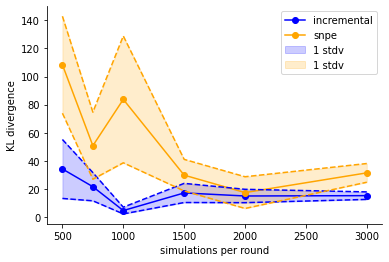

In [25]:


plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

plt.plot(num_simulations_list, upper_incremental, '--', color='blue')
plt.plot(num_simulations_list, upper_snpe, '--',  color='orange')

plt.plot(num_simulations_list, lower_incremental, '--',  color='blue')
plt.plot(num_simulations_list, lower_snpe, '--',  color='orange')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()

